In [1]:
##########################
#### standard library ####
##########################
import os
import copy
import time
import gc
from itertools import  filterfalse as ifilterfalse
import warnings
import random
from typing import List, Tuple, Dict, Any, Union, Optional, Sequence, Iterable, Callable
import shutil
# warnings.filterwarnings("ignore")

###################
#### 3rd party ####
###################
import torch
import torchaudio
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import AdamW
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import GradScaler, autocast #amp = automatic mixed precision
import lightning as L
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

######################
#### my own files ####
######################
pass

# Config

In [21]:
class Config:
    data_dir = "/home/nikita/Code/kaggle/Data/BirdCLEF2024_5s_32000Hz/"  #"/home/nikita/hdd/Data/BirdCLEF2024" # '/kaggle/input/birdclef-2024/'
    output_dir = "/home/nikita/Code/kaggle/BirdCLEF2024/output/"
    
    # Device and random seed
    device = 'cuda' # if torch.cuda.is_available() else 'cpu'
    seed = 42
    
    # upsample_thr = 50 # min sample of each class (upsample)
    # downsample_thr = 500 # max sample of each class (downsample)


    # Audio duration, sample rate, and length
    duration = 5 # second
    sample_rate = 4000
    audio_len = duration*sample_rate
    
    # Number of epochs, model name, and number of folds
    batch_size = 32
    epochs = 20
    n_folds = 5
    secondary_coef = 0.0 # If there are multiple bird labels, the target is also set to this coeff.
    label_smoothing = 0.00

    # Learning rate, optimizer, and cosine scheduler
    lr = 1e-1
    lr_min = 1e-3
    weight_decay = 1e-6
    gradient_clip_val = 1000.0
    optimizer = torch.optim.AdamW # AdamW, Adam

## 🌱 Seed Everything

In [22]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(Config.seed)

## Data

In [23]:
df = pd.read_csv(f"{Config.data_dir}/train_metadata.csv")
df["path"] = Config.data_dir + "/train_audio/" + df["filename"]
df["rating"] = np.clip(df["rating"] / df["rating"].max(), 0.1, 1.0)

skf = StratifiedKFold(n_splits=Config.n_folds, random_state=Config.seed, shuffle=True)
df['fold'] = -1
for ifold, (train_idx, val_idx) in enumerate(skf.split(X=df, y=df["primary_label"].values)):
    df.loc[val_idx, 'fold'] = ifold

sub = pd.read_csv(f"{Config.data_dir}/sample_submission.csv")
target_columns = sub.columns.tolist()[1:]
num_classes = len(target_columns)
bird2id = {b: i for i, b in enumerate(target_columns)}

In [24]:
# TODO remove: Playing around with a smaller dataset
df = df.sample(frac=1).reset_index(drop=True) #shuffle
df = df[df["rating"] >= 0.8]
df = df.iloc[0:1000]

## Dataset

In [25]:
def read_wav(path, new_freq = Config.sample_rate): # pip install sox       and      sudo apt-get install libsox-dev
    wav, org_sr = torchaudio.load(path, normalize=False)
    wav = torchaudio.functional.resample(wav, orig_freq=org_sr, new_freq=new_freq)
    return wav


def crop_start_wav(wav, duration_):
    while wav.size(-1) < duration_:
        wav = torch.cat([wav, wav], dim=1)
    wav = wav[:, :duration_]
    return wav


class BirdWavDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df # i.e. df["fold"!=0]
        self.bird2id = bird2id
        self.num_classes = num_classes
        self.secondary_coef = Config.secondary_coef
        self.transform = transform


    def __len__(self):
        return len(self.df)


    def prepare_target(self, primary_label, secondary_labels):
        secondary_labels = eval(secondary_labels)
        target = np.zeros(self.num_classes, dtype=np.float32)
        if primary_label != 'nocall':
            primary_label = self.bird2id[primary_label]
            target[primary_label] = 1.0
            for s in secondary_labels:
                if s != "" and s in self.bird2id.keys():
                    target[self.bird2id[s]] = self.secondary_coef
        target = torch.from_numpy(target).float()
        return target


    def __getitem__(self, idx):
        path = self.df["path"].iloc[idx]
        primary_label = self.df["primary_label"].iloc[idx]
        secondary_labels = self.df["secondary_labels"].iloc[idx]
        rating = self.df["rating"].iloc[idx]

        wav = read_wav(path)
        wav = crop_start_wav(wav, Config.audio_len)
        target = self.prepare_target(primary_label, secondary_labels)

        if self.transform is not None:
            wav = self.transform(wav)

        return {"wav": wav, "target": target, 'rating': rating}
    
# dataset = BirdWavDataset(df)
# batch = dataset[0]
# target = batch["target"].unsqueeze(0).to(Config.device)
# X = batch["wav"].unsqueeze(0).to(Config.device)
# print(target, target.shape, target.dtype)
# print("X", X.shape, X.dtype)

# model = Hydra(Config.audio_len, num_classes).to(Config.device)
# feat = model(X)
# print("feat", feat.shape)
# print("target", target.shape)

# cce_loss = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
# print(feat)
# cce_loss(feat, target)

## Model

In [26]:
# class HydraTransform(nn.Module):

#     def __init__(self, input_length, k = 8, g = 64):
#         super().__init__()

#         self.k = k # num kernels per group
#         self.g = g # num groups

#         max_exponent = np.log2((input_length - 1) / (9 - 1)) # kernel length = 9

#         self.dilations = 2 ** torch.arange(int(max_exponent) + 1)
#         self.num_dilations = len(self.dilations)

#         self.paddings = torch.div((9 - 1) * self.dilations, 2, rounding_mode = "floor").int()

#         self.divisor = min(2, self.g)
#         self.h = self.g // self.divisor

#         self.W = torch.randn(self.num_dilations, self.divisor, self.k * self.h, 1, 9).to(Config.device)
#         self.W = self.W - self.W.mean(-1, keepdims = True)
#         self.W = self.W / self.W.abs().sum(-1, keepdims = True)
        

#     # transform in batches of *batch_size*
#     def batch(self, X, batch_size = 8):
#         num_examples = X.shape[0]
#         if num_examples <= batch_size:
#             return self(X)
#         else:
#             Z = []
#             batches = torch.split(X, batch_size)
#             for batch in batches:
#                 Z.append(self(X[batch]))
#             return torch.cat(Z)


#     def forward(self, X):
#         num_examples = X.shape[0]

#         if self.divisor > 1:
#             diff_X = torch.diff(X)

#         Z = []

#         for dilation_index in range(self.num_dilations):

#             d = self.dilations[dilation_index].item()
#             p = self.paddings[dilation_index].item()

#             for diff_index in range(self.divisor):

#                 _Z = F.conv1d(X if diff_index == 0 else diff_X, self.W[dilation_index, diff_index], dilation = d, padding = p) \
#                       .view(num_examples, self.h, self.k, -1)

#                 max_values, max_indices = _Z.max(2)
#                 count_max = torch.zeros_like(_Z[:,:,:, 0])

#                 min_values, min_indices = _Z.min(2)
#                 count_min = torch.zeros_like(_Z[:,:,:, 0])

#                 count_max.scatter_add_(-1, max_indices, max_values)
#                 count_min.scatter_add_(-1, min_indices, torch.ones_like(min_values))

#                 Z.append(count_max)
#                 Z.append(count_min)

#         Z = torch.cat(Z, 1).view(num_examples, -1)

#         return Z
    

# class Hydra(nn.Module):
#     def __init__(self, wav_input_length, num_classes, k = 8, g = 64):
#         super().__init__()
#         self.hydra_trans = HydraTransform(wav_input_length, k, g).to(Config.device)

#         n_dilations, n_divisor, n_k_h = self.hydra_trans.W.shape[0:3]
#         self.fc = nn.Linear(2 * n_dilations * n_divisor * n_k_h, num_classes).to(Config.device)


#     def forward(self, X):
#         X = self.hydra_trans(X)
#         return self.fc(X)



# # dataset = BirdWavDataset(df[df["fold"] != 0])
# # wav = dataset[0]["wav"]
# # print("wav", wav.shape)
# # hydra = Hydra(Config.audio_len, num_classes, k=8, g=64)
# # output = hydra(wav.unsqueeze(0))
# # print("output", output.shape)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
import itertools

# %% ../../nbs/057_models.MINIROCKETPlus_Pytorch.ipynb 4
class MiniRocketFeaturesPlus(nn.Module):
    fitting = False

    def __init__(self, c_in, seq_len, num_features=10_000, max_dilations_per_kernel=32, kernel_size=9, max_num_channels=9, max_num_kernels=84,
                 add_lsaz=False):
        super(MiniRocketFeaturesPlus, self).__init__()
        self.c_in, self.seq_len = c_in, seq_len
        self.kernel_size, self.max_num_channels, self.add_lsaz = kernel_size, max_num_channels, add_lsaz

        # Kernels
        indices, pos_values = self.get_indices(kernel_size, max_num_kernels)
        self.num_kernels = len(indices)
        kernels = (-torch.ones(self.num_kernels, 1, self.kernel_size)).scatter_(2, indices, pos_values)
        self.indices = indices
        self.kernels = nn.Parameter(kernels.repeat(c_in, 1, 1), requires_grad=False)
        if add_lsaz:
            num_features = num_features // 2
        self.num_features = num_features // self.num_kernels * self.num_kernels
        self.max_dilations_per_kernel = max_dilations_per_kernel

        # Dilations
        self.set_dilations(seq_len)

        # Channel combinations (multivariate)
        if c_in > 1:
            self.set_channel_combinations(c_in, max_num_channels)

        # Bias
        for i in range(self.num_dilations):
            self.register_buffer(f'biases_{i}', torch.empty(
                (self.num_kernels, self.num_features_per_dilation[i])))
        self.register_buffer('prefit', torch.BoolTensor([False]))

    def forward(self, x):
        _features = []
        for i, (dilation, padding) in enumerate(zip(self.dilations, self.padding)):
            _padding1 = i % 2

            # Convolution
            C = F.conv1d(x, self.kernels, padding=padding,
                         dilation=dilation, groups=self.c_in)
            if self.c_in > 1:  # multivariate
                C = C.reshape(x.shape[0], self.c_in, self.num_kernels, -1)
                channel_combination = getattr(
                    self, f'channel_combinations_{i}')
                C = torch.mul(C, channel_combination)
                C = C.sum(1)

            # Bias
            if not self.prefit or self.fitting:
                num_features_this_dilation = self.num_features_per_dilation[i]
                bias_this_dilation = self.get_bias(
                    C, num_features_this_dilation)
                setattr(self, f'biases_{i}', bias_this_dilation)
                if self.fitting:
                    if i < self.num_dilations - 1:
                        continue
                    else:
                        self.prefit = torch.BoolTensor([True])
                        return
                elif i == self.num_dilations - 1:
                    self.prefit = torch.BoolTensor([True])
            else:
                bias_this_dilation = getattr(self, f'biases_{i}')

            # Features
            _features.append(self.get_PPVs(
                C[:, _padding1::2], bias_this_dilation[_padding1::2]))
            _features.append(self.get_PPVs(
                C[:, 1-_padding1::2, padding:-padding], bias_this_dilation[1-_padding1::2]))

        return torch.cat(_features, dim=1)

    def fit(self, X, chunksize=None):
        num_samples = X.shape[0]
        if chunksize is None:
            chunksize = min(num_samples, self.num_dilations * self.num_kernels)
        else: 
            chunksize = min(num_samples, chunksize)
        idxs = np.random.choice(num_samples, chunksize, False)
        self.fitting = True
        if isinstance(X, np.ndarray): 
            self(torch.from_numpy(X[idxs]).to(self.kernels.device))
        else:
            self(X[idxs].to(self.kernels.device))
        self.fitting = False

    def get_PPVs(self, C, bias):
        C = C.unsqueeze(-1)
        bias = bias.view(1, bias.shape[0], 1, bias.shape[1])
        a = (C > bias).float().mean(2).flatten(1)
        if self.add_lsaz:
            dif = (C - bias)
            b = (F.relu(dif).sum(2) /
                 torch.clamp_min(torch.abs(dif).sum(2), 1e-8)).flatten(1)
            return torch.cat((a, b), dim=1)
        else:
            return a

    def set_dilations(self, input_length):
        num_features_per_kernel = self.num_features // self.num_kernels
        true_max_dilations_per_kernel = min(
            num_features_per_kernel, self.max_dilations_per_kernel)
        multiplier = num_features_per_kernel / true_max_dilations_per_kernel
        max_exponent = np.log2((input_length - 1) / (self.kernel_size - 1))
        dilations, num_features_per_dilation = \
            np.unique(np.logspace(0, max_exponent, true_max_dilations_per_kernel, base=2).astype(
                np.int32), return_counts=True)
        num_features_per_dilation = (
            num_features_per_dilation * multiplier).astype(np.int32)
        remainder = num_features_per_kernel - num_features_per_dilation.sum()
        i = 0
        while remainder > 0:
            num_features_per_dilation[i] += 1
            remainder -= 1
            i = (i + 1) % len(num_features_per_dilation)
        self.num_features_per_dilation = num_features_per_dilation
        self.num_dilations = len(dilations)
        self.dilations = dilations
        self.padding = []
        for i, dilation in enumerate(dilations):
            self.padding.append((((self.kernel_size - 1) * dilation) // 2))

    def set_channel_combinations(self, num_channels, max_num_channels):
        num_combinations = self.num_kernels * self.num_dilations
        if max_num_channels:
            max_num_channels = min(num_channels, max_num_channels)
        else:
            max_num_channels = num_channels
        max_exponent_channels = np.log2(max_num_channels + 1)
        num_channels_per_combination = (
            2 ** np.random.uniform(0, max_exponent_channels, num_combinations)).astype(np.int32)
        self.num_channels_per_combination = num_channels_per_combination
        channel_combinations = torch.zeros(
            (1, num_channels, num_combinations, 1))
        for i in range(num_combinations):
            channel_combinations[:, np.random.choice(
                num_channels, num_channels_per_combination[i], False), i] = 1
        channel_combinations = torch.split(
            channel_combinations, self.num_kernels, 2)  # split by dilation
        for i, channel_combination in enumerate(channel_combinations):
            self.register_buffer(
                f'channel_combinations_{i}', channel_combination)  # per dilation

    def get_quantiles(self, n):
        return torch.tensor([(_ * ((np.sqrt(5) + 1) / 2)) % 1 for _ in range(1, n + 1)]).float()

    def get_bias(self, C, num_features_this_dilation):
        isp = torch.randint(C.shape[0], (self.num_kernels,))
        samples = C[isp].diagonal().T
        biases = torch.quantile(samples, self.get_quantiles(
            num_features_this_dilation).to(C.device), dim=1).T
        return biases

    def get_indices(self, kernel_size, max_num_kernels):
        num_pos_values = math.ceil(kernel_size / 3)
        num_neg_values = kernel_size - num_pos_values
        pos_values = num_neg_values / num_pos_values
        if kernel_size > 9:
            random_kernels = [np.sort(np.random.choice(kernel_size, num_pos_values, False)).reshape(
                1, -1) for _ in range(max_num_kernels)]
            indices = torch.from_numpy(
                np.concatenate(random_kernels, 0)).unsqueeze(1)
        else:
            indices = torch.LongTensor(list(itertools.combinations(
                np.arange(kernel_size), num_pos_values))).unsqueeze(1)
            if max_num_kernels and len(indices) > max_num_kernels:
                indices = indices[np.sort(np.random.choice(
                    len(indices), max_num_kernels, False))]
        return indices, pos_values

# %% ../../nbs/057_models.MINIROCKETPlus_Pytorch.ipynb 5
class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    

class MiniRocketPlus(nn.Sequential):

    def __init__(self, c_in, c_out, seq_len, num_features=10_000, max_dilations_per_kernel=32, kernel_size=9, max_num_channels=None, max_num_kernels=84,
                 bn=True, fc_dropout=0, add_lsaz=False, custom_head=None, zero_init=True):

        # Backbone
        backbone = MiniRocketFeaturesPlus(c_in, seq_len, num_features=num_features, max_dilations_per_kernel=max_dilations_per_kernel,
                                          kernel_size=kernel_size, max_num_channels=max_num_channels, max_num_kernels=max_num_kernels,
                                          add_lsaz=add_lsaz)
        num_features = backbone.num_features * (1 + add_lsaz)

        # Head
        self.head_nf = num_features
        if custom_head is not None: 
            if isinstance(custom_head, nn.Module): head = custom_head
            else: head = custom_head(self.head_nf, c_out, 1)
        else:
            layers = [Flatten()]
            if bn:
                layers += [nn.BatchNorm1d(num_features)]
            if fc_dropout:
                layers += [nn.Dropout(fc_dropout)]
            linear = nn.Linear(num_features, c_out)
            if zero_init:
                nn.init.constant_(linear.weight.data, 0)
                nn.init.constant_(linear.bias.data, 0)
            layers += [linear]
            head = nn.Sequential(*layers)

        super().__init__(OrderedDict([('backbone', backbone), ('head', head)]))


## ⚡ PyTorch Lightning

In [28]:
class LightningHydra(L.LightningModule):
    def __init__(self, wav_input_length, num_classes, k = 8, g = 64):
        super().__init__()
        #self.hydra = Hydra(wav_input_length, num_classes, k, g)
        #self.hydra = nn.Linear(wav_input_length, num_classes)
        self.rocket = MiniRocketPlus(1, num_classes, wav_input_length, num_features=20_000)
        self.cce_loss = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
    

    def training_step(self, batch, batch_idx):
        X = batch["wav"]
        targets = batch["target"]
        #print("TARGETS", targets.shape, targets, targets.dtype)
        
        logits = self.rocket(X)
        loss = self.cce_loss(logits, targets)
        # print("X", X.shape, "mean abs", X.abs().mean())
        # print("logits", logits.shape, "mean abs", logits.abs().mean())
        self.log("train_loss", loss)
        return loss


    def validation_step(self, batch, batch_idx):
        X = batch["wav"]
        targets = batch["target"]

        logits = self.rocket(X)
        val_loss = self.cce_loss(logits, targets)
        self.log("val_loss", val_loss)


    def configure_optimizers(self):
        optimizer = Config.optimizer(
                #self.hydra.fc.parameters(), TODO
                self.rocket.parameters(), 
                lr=Config.lr,
                weight_decay=Config.weight_decay
            )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max=Config.epochs, 
                eta_min=Config.lr_min
            )
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [29]:
def train_fold(fold_idx:int = 0):
    #create DataLoaders for train and val
    train_df = df[df["fold"] != fold_idx]
    val_df = df[df["fold"] == fold_idx]
    train_dataset = BirdWavDataset(train_df)
    val_dataset = BirdWavDataset(val_df)
    train_loader = DataLoader(train_dataset, Config.batch_size, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_dataset, Config.batch_size, shuffle=False, num_workers=1)

    model = LightningHydra(Config.audio_len, num_classes, k=4, g=32).to(Config.device)
    trainer = L.Trainer(
            accelerator="gpu",
            max_epochs=Config.epochs,
            gradient_clip_val=Config.gradient_clip_val,
            num_sanity_val_steps=0,
        )
    trainer.fit(model, train_loader, val_loader)

In [30]:
train_fold(0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | rocket   | MiniRocketPlus   | 3.7 M 
1 | cce_loss | CrossEntropyLoss | 0     
----------------------------------------------
3.7 M     Trainable params
756       Non-trainable params
3.7 M     Total params
14.718    Total estimated model params size (MB)
/home/nikita/Code/zephyrox/.conda/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/nikita/Code/zephyrox/.conda/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches

Epoch 0: 100%|██████████| 25/25 [00:41<00:00,  0.60it/s, v_num=13]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 25/25 [00:41<00:00,  0.61it/s, v_num=13]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 25/25 [00:43<00:00,  0.58it/s, v_num=13]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 25/25 [00:44<00:00,  0.56it/s, v_num=13]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 25/25 [00:45<00:00,  0.55it/s, v_num=13]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 25/25 [00:45<00:00,  0.55it/s, v_num=13]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 25/25 [00:46<00:00,  0.54it/s, v_num=13]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 25/25 [00:46<00:00,  0.54it/s, v_num=13]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 25/25 [00:47<00:00,  0.52it/s, v_num=13]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 25/25 [01:01<00:00,  0.40it/s, v_num=13]


wav1.shape: torch.Size([1, 160704])
wav2.shape: torch.Size([1, 80352])


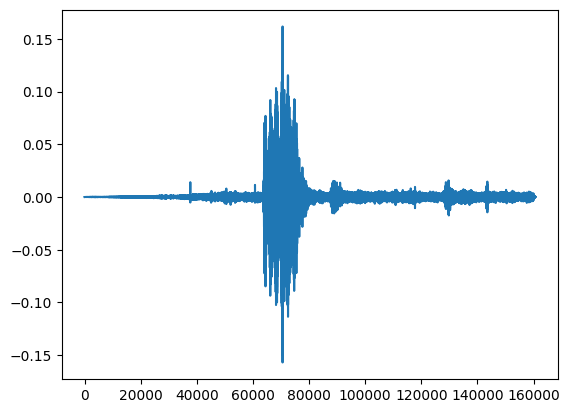

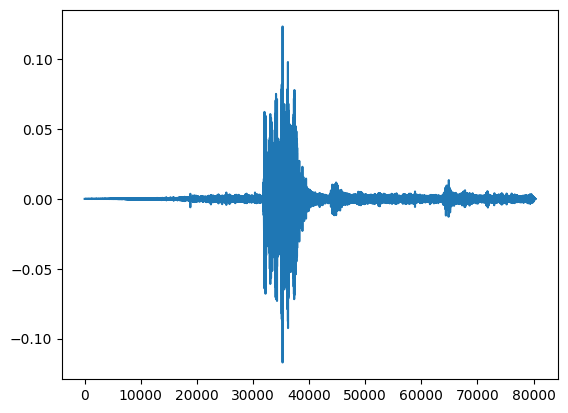

In [11]:
#testing
path = Config.data_dir + "/train_audio/asbfly/XC134896.ogg"
wav1 = read_wav(path, 32000)
wav2 = read_wav(path, 16000)
print("wav1.shape:", wav1.shape)
print("wav2.shape:", wav2.shape)

plt.plot(wav1[0].numpy())
plt.show()
plt.plot(wav2[0].numpy())
plt.show()